<a href="https://colab.research.google.com/github/afsanamimii/Go-Greener-A-leaf-classification-app-using-Tensorflow-/blob/main/thesis_work_Transfer_Learning(Mimi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
]import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from zipfile import ZipFile
import os
file_name="FINAL_THESIS_DATASET.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  base_dir='/content/FINAL_THESIS_DATASET/NoyontaraandStrawberry'
  print("done")

done


In [ ]:
#pre processing
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    validation_split=0.1)


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
     validation_split=0.1 
                   )

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = validation_datagen .flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')



Found 3426 images belonging to 4 classes.
Found 378 images belonging to 4 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 4))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Catharanthus_roseus_Yellow': 0, 'Catharanthus_roseus_healthy': 1, 'Strawberry_healthy': 2, 'Strawberry_leaf_scrotch': 3}


In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:


model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
epochs =10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
54/54 [==============================] - 179s 3s/step - loss: 0.3863 - accuracy: 0.8227 - val_loss: 0.0654 - val_accuracy: 0.9841
Epoch 2/10
54/54 [==============================] - 174s 3s/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.3226 - val_accuracy: 0.8942
Epoch 3/10
54/54 [==============================] - 175s 3s/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.0812 - val_accuracy: 0.9683
Epoch 4/10
54/54 [==============================] - 182s 3s/step - loss: 0.0282 - accuracy: 0.9886 - val_loss: 0.1148 - val_accuracy: 0.9603
Epoch 5/10
54/54 [==============================] - 173s 3s/step - loss: 0.0139 - accuracy: 0.9930 - val_loss: 0.2186 - val_accuracy: 0.9339
Epoch 6/10
54/54 [==============================] - 174s 3s/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.1703 - val_accuracy: 0.9471
Epoch 7/10
54/54 [==============================] - 172s 3s/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.1538 - val_accuracy: 0.9444
Epoch 8/10
54

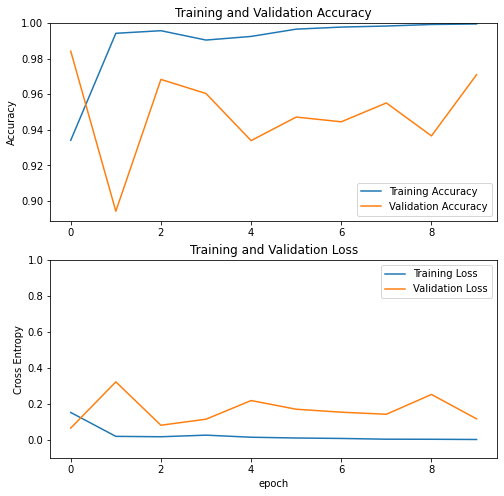

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-0.1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
saved_model_dir = 'save/fine_tuning_n1'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/fine_tuning_n1/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: ignored